In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


In [4]:
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [5]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

In [6]:
def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## Hypothesis 2

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ as a continious predictor. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$

The priors for $\alpha$ and $\beta_{A}$ are not yet defined. In the following sections we determine reasonable priors for them.

$$
\alpha = \text{Not determined yet}
$$

$$
\beta_{A} = \text{Not determined yet}
$$

#### Determine prior for $\alpha$

Using the log-link function changes the outcome scale, which in turn has an effect on the priors. We therefore have to be careful when defining the priors, because the outcome scale of the prior is not linear. 

To simulate and explore the effects of possible priors for $\alpha$, we create a model that only contains $\alpha$ and does not include $\beta_{A}$

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

$$
ln(\lambda_i) = \alpha 
$$


$$
\alpha = \text{Not determined yet}
$$


In [7]:
def prior_predictive_check_alpha(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lam', pm.math.exp(alpha))
        B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
        trace = pm.sample_prior_predictive(samples=500)
        
    return trace, model

When using standardized age, $\alpha$ corresponds to the $ln(\lambda)$ when age is equal to mean age. 

In the prior predictive check, we want $\alpha$ to generate a density for number of commits classified as bugs $B$ that is within a reasonable range. From our experience with GitHub, we have rarely had more than 100 commits on a project. But we also think that other projects are likely to have many more commits.   

We explore possible values for $\alpha$ by plotting the density of alpha using the prior predictive check.

Sampling: [B, alpha]


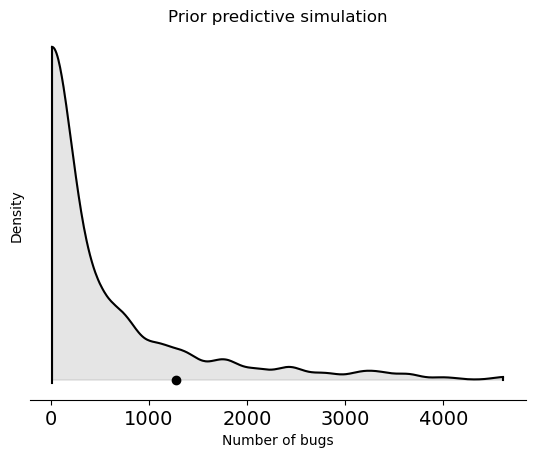

In [8]:
h1_alpha_idata, h1_alpha_model = prior_predictive_check_alpha(6,1.5)

az.plot_density(
    h1_alpha_idata.prior['lam'],
    colors='black',
    hdi_prob=0.95,
    point_estimate='mean',
    shade=0.1)
plt.title('Prior predictive simulation')
plt.xlabel('Number of bugs')
plt.ylabel('Density');

We define the prior for $\alpha$ to be $\mathcal{N}(6, 1.5)$.

This seems like a reasonable prior. It assings the expectation of $\alpha$ to be around $1.200$ bugs (see point estimiate on x-axis), while also assigning high probability to fewer than $1000$ bugs.

#### Determine prior for $\beta_A$ 

Next, we determine the prior for $\beta_A$.

We use standardized age, which makes the coefficients easier to interpret.

In [9]:
df['age_std'] = standardize_column(df['age'])

We simulate the effect of varying the prior for $\beta_{A}$ by sampling N alphas with the fixed prior that we determined earlier, and sampling N betas where we can vary the prior.

We then plot the effect of $\beta_{A}$ by varying standardized age from -3 to 3, corresponding to 3 standard deviations below and above the mean of age. We can then see how strong (or not strong) the prior effect of $\beta_{A}$ on number of bugs is.

In [10]:
#Inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

def plot_prior_continious(b_mean: int = 0, b_std: int = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("Age (std)")
    plt.ylabel('Number of bugs')
    
    return plt

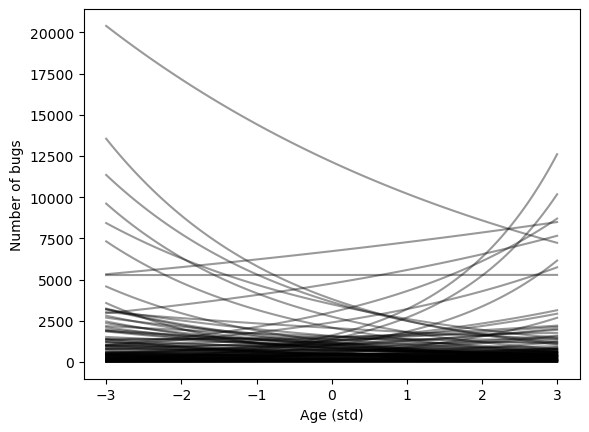

In [11]:
plot_prior_continious(0, .3);

These effects of age seem plausible, and they allow for high values in number of bugs. They also allow for both positive and negative impact of age on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of age. But we also dont expect explosive and unrealistic effects of age. 


We determine the prior to be $\beta_A \sim \mathcal{N}(0, 0.3)$

#### Fit model

We fit the model using the determined priors.

In [12]:
def create_model_h2(alpha_mu_prior, alpha_sigma_prior, 
                    beta_mu_prior, beta_sigma_prior, 
                    save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    #Compuate lambda and sample number of bugs
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [13]:
h2_idata, h2_model = create_model_h2(6, 1.5, 
                                     0, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 103 seconds.


The model has a single estimate for $\alpha$ and $\beta_A$, which determine $\lambda$ together with standardized age.

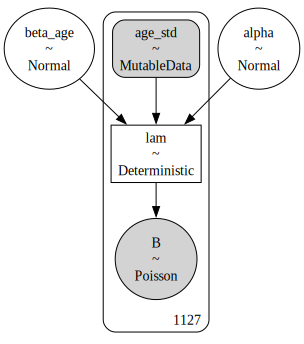

In [14]:
pm.model_to_graphviz(h2_model)

Below is the trace convergence for the parameters `alpha` and `beta_age`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have a good mixing. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [15]:
pm.summary(h2_idata, var_names=['alpha', 'beta_age'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.08,0.0,6.08,6.09,0.0,0.0,6554.30,5733.46,1.0
beta_age,0.34,0.0,0.34,0.34,0.0,0.0,6704.81,5893.00,1.0


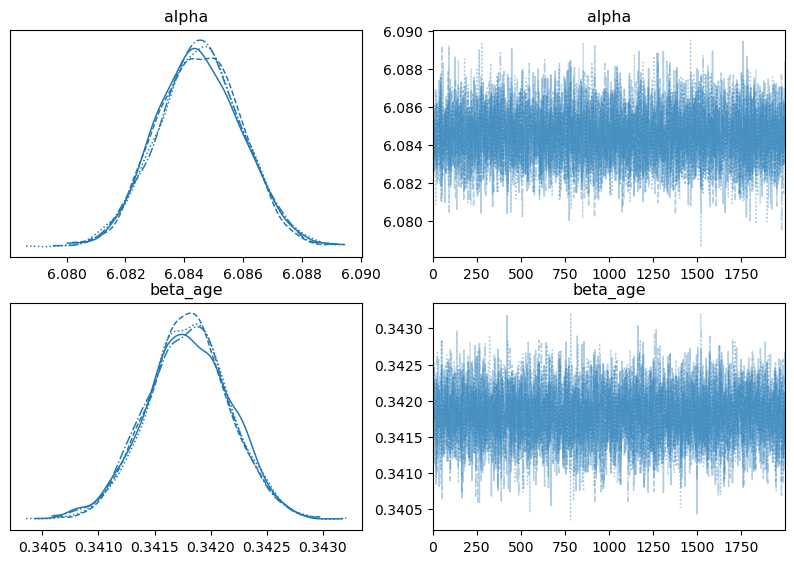

In [16]:
az.plot_trace(h2_idata, var_names = ['alpha','beta_age'], figsize=(10,6.5));

The forest plot shows that the standard deviations for the estimates for both `alpha` and `beta_age` are very small. We also note that the effect of `alpha` is much larger than the effect of `beta_age`.

The posterior mean of `alpha` is close to the prior we defined $\mathcal{N}(6, 1.5)$, but it has become a lot more confident - it has a posterior sd of 0.0014.

The posterior mean `beta_age` has moved in positive direction from its prior of $\mathcal{N}(0, 0.3)$. The posterior sd is a lot more confident than the prior sd.

In [17]:
pm.summary(h2_idata, var_names=['alpha', 'beta_age'],round_to=4)[['mean', 'sd']]

,mean,sd
alpha,6.0845,0.0014
beta_age,0.3418,0.0004


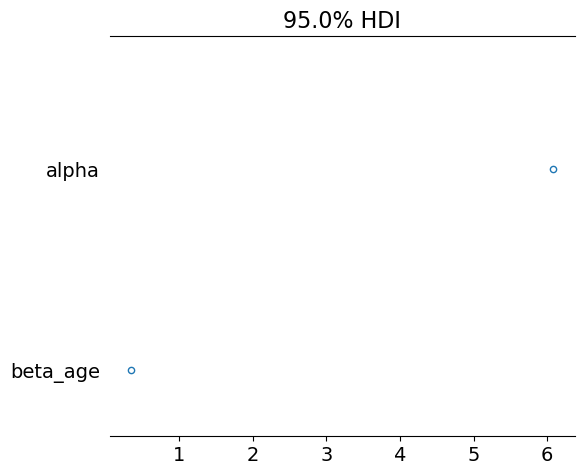

In [18]:
az.plot_forest(h2_idata, var_names = ['alpha', 'beta_age'], hdi_prob=.95, combined=True);

#### Posterior Predictive Check

Next we use the posterior estimates to make posterior predictive check and see how the model fits the data.

We calculate pareto k values for the data-points, to see influential data-points. We get a warning that some samples have a pareto k value higher than $0.7$, and are therefore considered highly influential. 

In [19]:
pareto_k_h2 = az.loo(h2_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


We sample $1.127$ points linearly from values between $-1.5$ and $14$, and use these to sample the posterior predictive estimates.

In [20]:
print(f"Min age std: {df.age_std.min():.2f}")
print(f"Max age std: {df.age_std.max():.2f}")

Min age std: -1.14
Max age std: 13.29


In [21]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-1.5, 13, n_points)

with h2_model:
    pm.set_data({"age_std": x_seq})
    post_pred_h2 = pm.sample_posterior_predictive(h2_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h2_mean = post_pred_h2.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


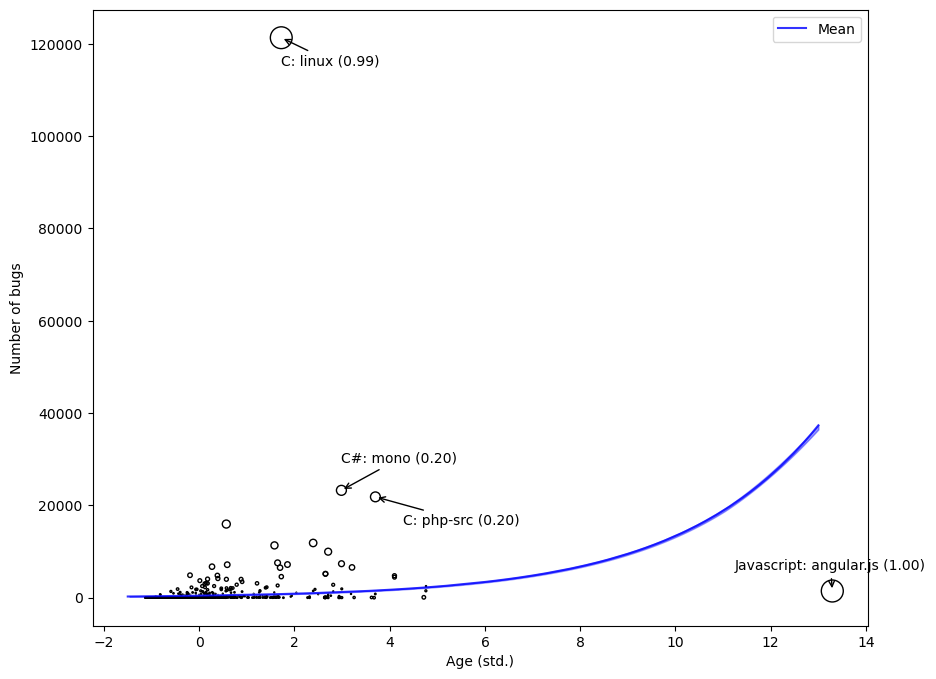

In [22]:
plt.figure(figsize=(10,8))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h2 /= pareto_k_h2.max()
pareto_k_h2_size = 250 * pareto_k_h2

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h2)[-10:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.8, label='Mean')
plt.scatter(df.age_std, df.bugs, s = pareto_k_h2_size, facecolors='none', edgecolors='k', lw=1)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    dont_annotate = False
    if row['language'] == 'C' and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 'Javascript':
        position=(-70,15)
    elif row['language'] == 'C#' and row['project'] == 'mono':
        position=(0,20)
    elif row['language'] == 'C' and row['project'] == 'php-src':
        position=(20,-20)
    else:
        dont_annotate = True
    if dont_annotate == False:
        plt.annotate(f"{row['language']}: {row['project']} ({pareto_k_h2[index]:.2f})", xy=(row['age_std'], row['bugs']), xytext=position,
                    textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.legend();
plt.xlabel('Age (std.)');
plt.ylabel('Number of bugs');

What jumps out of this figure is the existance of very influential data-points. In particular *C: Linux* which has many more bugs for its age compared to the other data-points, and *Javascript: angular.js* which is an old project but still has few bugs. It is important to note that we should not discard these data-points.

However, to better vizualise the posterior predictions we "zoom in" on the data-points by removing the influential data-points from the figure.

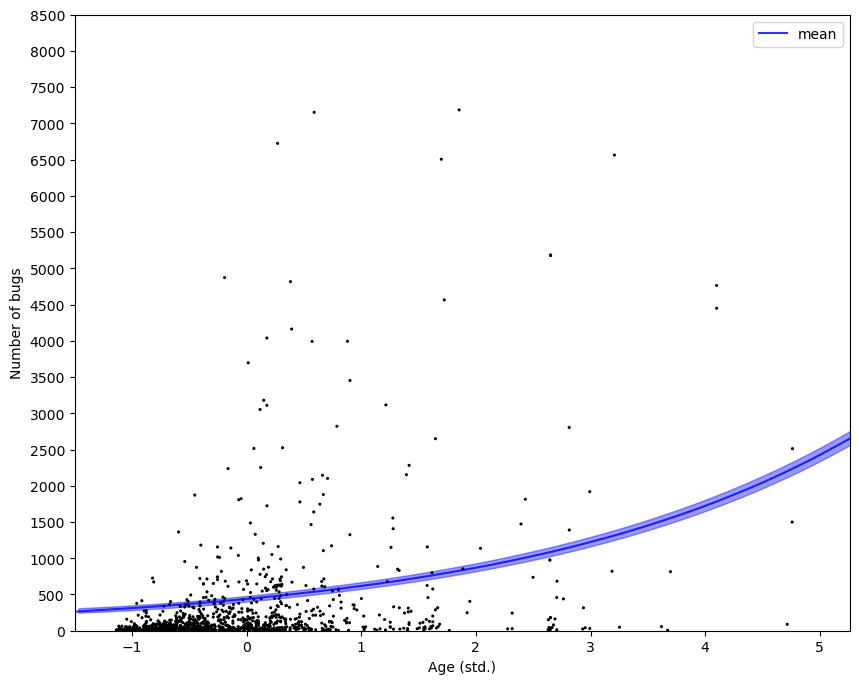

In [23]:
plt.figure(figsize=(10,8))

pareto_k_size_without_top = np.delete(pareto_k_h2_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.8, label='mean')
plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('Age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

We see a positive effect of age, which was also reflected in the posterior estimate of `beta_age` which was 0.34. In addition we see that the number of bugs is around 450 when standardized age is 0. This is given by the `alpha` = 6.08 which corresponds to $exp(6.08) = 437$.

The plot also shows small uncertainty of the mean, although the uncertainty grows slighly as standardized age increases. 

Based on these observations, we conclude that age has a positive impact on number of bugs. A project/language with old age have a larger number of bugs.

However, we suspect that the association of age with bugs could be a result of omitted variable bias. In hypothesis 3 we examine whether stratifying by commits will lower the strength of the association with age on bugs.


## Hypothesis 3

* **H3** - Number of commits (C) does not impact the effect of age (A) on the number of bugs (B) for any programming language (L). That is, the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

In hypothesis 3 we examine whether the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

We treat commits as a confounding variable that is affecting age and bugs through a "fork-effect".

In hypothesis 2 we saw that age (X) was associated with bugs (Y). In hypothesis 3 we strafiy by commits (Z) and examine whether the effect of age changes compared to hypothesis 2.  

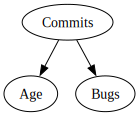

In [24]:
CausalGraphicalModel(
    nodes=["Commits", "Bugs", "Age"],
    edges=[
        ("Commits", "Bugs"), 
        ("Commits", "Age"), 
    ]
).draw()

As before we model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ and standardized commits $C$ as a continious predictors. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i + \beta_{C}C_i
$$

We re-use the priors for $\alpha$ and  $\beta_A$ that we determined in H2.

$$
\alpha \sim \mathcal{N}(6, 1.5)
$$

$$
\beta_A \sim \mathcal{N}(0, 0.3)
$$

We determine the prior for $\beta_{C}$ in the following section.

$$
\beta_C = \text{Not determined yet}
$$

#### Determine prior for $\beta_C$ 

We use standardized commits, which makes the coefficients easier to interpret, while also allowing us to remove the effect of commits in the posterior predictive check.

In [25]:
df['commits_std'] = standardize_column(df['commits'])

In the prior for $\beta_A$ we allowed for both positive and negative impact of age on the number of bugs, with many priors being quite flat.

We dont want the same behavior in the prior for the effect of number of commits on number of bugs: $\beta_C$. This is because we know that bugs is defined as the number of commits classified as bugs. This means that commits can *not* have a negative impact on the number of bugs. This is simply impossible. So we want a prior for $\beta_C$ that only allows positive relationships.

We choose to use a log-normal distribution for $\beta_C$ which only has positive values.

In [26]:
def plot_prior_continuous_lognormal(b_mean: float = 0, b_std: float = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.lognormal(mean=b_mean, sigma=b_std, size=N)
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("commits (std)")
    plt.ylabel('Number of bugs')
    
    return plt

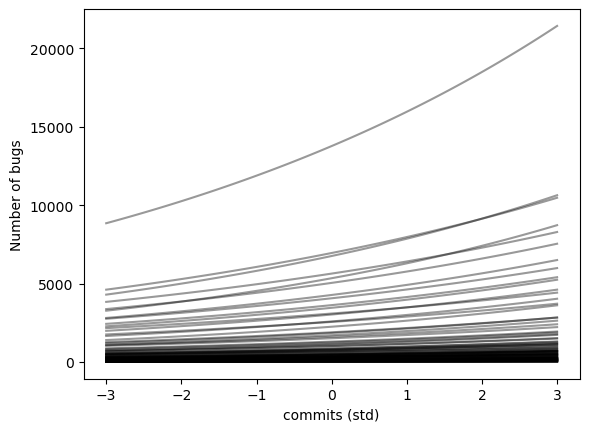

In [27]:
plot_prior_continuous_lognormal(b_mean=-2, b_std=0.1);

These effects of commits seem plausible. They are all positive, and some of them allow for quite strong relationships.

We determine the prior to be $\beta_C \sim \text{LogNormal}(-2, 0.1)$.

#### Fit model

We fit the model using the determined priors.

In [28]:
def create_model_h3(alpha_mu_prior, alpha_sigma_prior,
                    beta_age_mu_prior, beta_age_sigma_prior, 
                    beta_com_mu_prior, beta_com_sigma_prior, 
                    save_name='', save=False):
  '''
  Creates model for hypothesis 3. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_age_mu_prior, sigma=beta_age_sigma_prior)
    beta_commits = pm.Lognormal('beta_commits', mu=beta_com_mu_prior, sigma=beta_com_sigma_prior)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    commits_std = pm.Data("commits_std", df.commits_std, mutable=True)
    
    #Compuate lambda and sample number of bugs
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_commits*commits_std + beta_age*age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [30]:
h3_idata, h3_model = create_model_h3(6, 1.5,
                                     0, 0.3,
                                     -2, 0.1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_commits]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 94 seconds.


The model has a single estimate for $\alpha$, $\beta_A$ and $\beta_C$, which determine $\lambda$ together with standardized age and standardized commits.

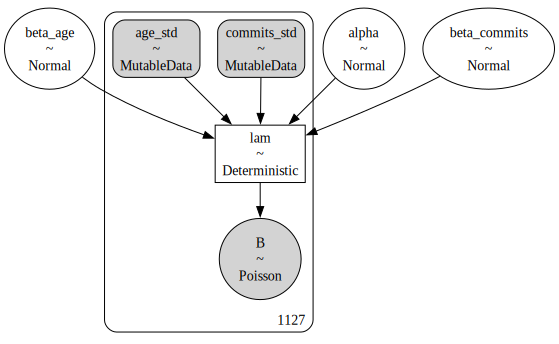

In [31]:
pm.model_to_graphviz(h3_model)

Below is the trace convergence for the parameters `alpha`,  `beta_age`, and `beta_commits`

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.

We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 3 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [33]:
pm.summary(h3_idata, var_names=['alpha', 'beta_age', 'beta_commits'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.82,0.0,5.81,5.82,0.0,0.0,5503.02,6487.68,1.0
beta_age,0.33,0.0,0.32,0.33,0.0,0.0,6511.70,5731.26,1.0
beta_commits,0.17,0.0,0.17,0.17,0.0,0.0,5969.22,5522.82,1.0


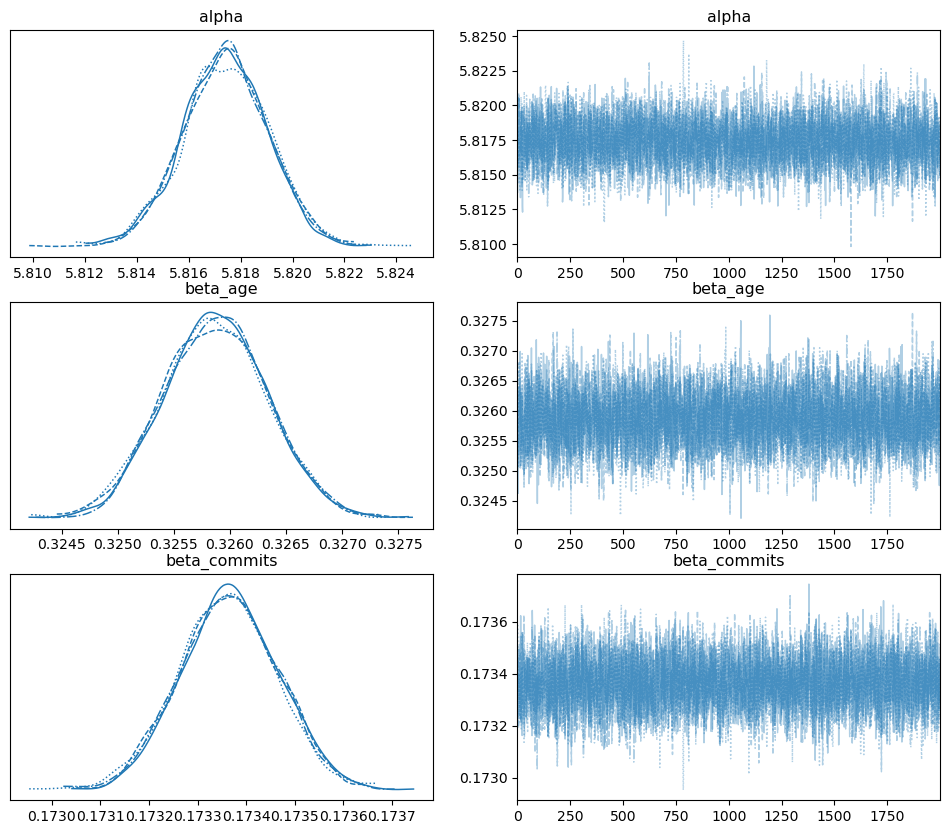

In [37]:
az.plot_trace(h3_idata, var_names = ['alpha','beta_age', 'beta_commits'], figsize=(12,10));

The forest plot below shows that the standard deviations for the estimates for both `alpha`, `beta_age`, and `beta_commits` are very small. We also note that the effect of `alpha` is much larger than the effect of `beta_age` and `beta_commits`.

Contrary to what we expected, `beta_age` actually has a larger effect than `beta_commits`. We expected `beta_commits` to have a larger effect because it is closely associated with number of bugs (bugs is defined as the number of commits classified as a bug). 

In [40]:
pm.summary(h3_idata, var_names=['alpha', 'beta_age', 'beta_commits'],round_to=4)[['mean', 'sd']]

,mean,sd
alpha,5.8174,0.0016
beta_age,0.3259,0.0005
beta_commits,0.1734,0.0001


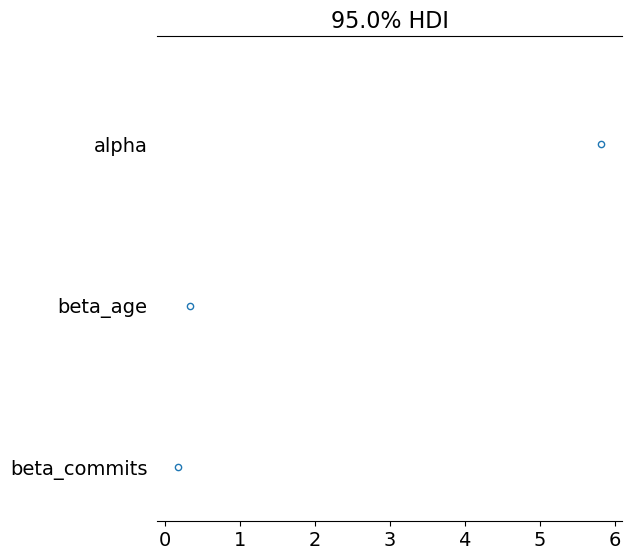

In [41]:
az.plot_forest(h3_idata, var_names = ['alpha','beta_age', 'beta_commits'], hdi_prob=.95, combined=True);

Next we compare the effect of age on number of bugs without conditioning on the number of commits (H2) and with conditioning on the number of commits (H3). 

We see a notable difference between the effect of age in the two models in the forest plot. The effect of age on the number of bugs conditioned by the number of commits is confidently lower than the direct effect of age. 

Nonetheless, the difference seems quite small when looking at the estimates. It will be easier to compare them in the next section of posterior predictions.

In [43]:
print(f"Decrease in posterior mean of beta_age from H2 to H3: {round(pm.summary(h3_idata, var_names=['beta_age'],round_to=4)['mean'].values[0]-pm.summary(h2_idata, var_names=['beta_age'],round_to=4)['mean'].values[0], 4)}")

Decrease in posterior mean of beta_age from H2 to H3: -0.0159


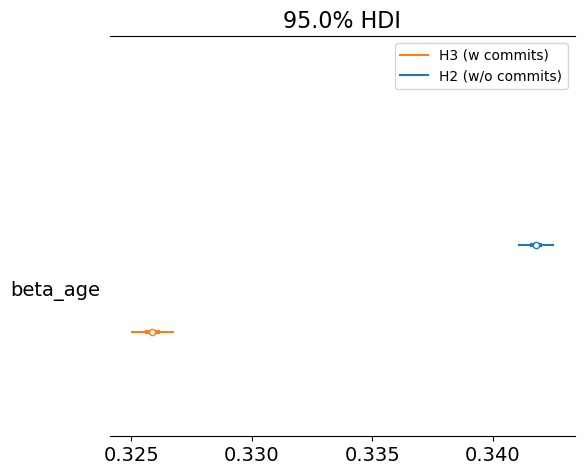

In [44]:
az.plot_forest(
    data=[h2_idata, h3_idata],
    model_names = ['H2 (w/o commits)','H3 (w commits)'],
    var_names=['beta_age'],
    hdi_prob=.95,
    combined=True);

#### Posterior Predictive Checks for Age

We calculate pareto k values for the data-points, to see influential data-points. We get the same warning as in H2.

In [42]:
pareto_k_h3 = az.loo(h3_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


For standardized age, we sample $1.127$ points linearly from values between $-1.5$ and $14$, exactly like in H2.

For standardized commits, we sample $1.127$ points of 0. This is simply to remove the effect of `beta_commits`.

This means that we can compare the posterior predictions of the model in H3 with the model in H2 when varying standardized age.

In [43]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-1.5, 13, n_points)

with h3_model:
    pm.set_data({"age_std": x_seq, "commits_std": np.repeat(0, n_points)})
    post_pred_h3 = pm.sample_posterior_predictive(h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h3_mean = post_pred_h3.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


We remove the influential data-points from the figure so it is easier to compare the two models.

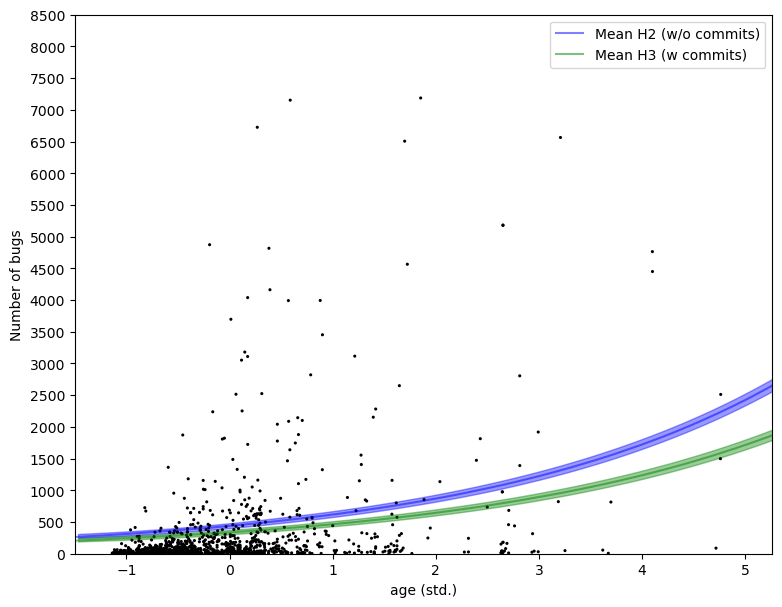

In [44]:
plt.figure(figsize=(9,7))

pareto_k_h3 /= pareto_k_h3.max()
pareto_k_h3_size = 250 * pareto_k_h3

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h3)[-10:][::-1]

pareto_k_size_without_top = np.delete(pareto_k_h3_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h2_mean, color = 'b', alpha=0.5, label='Mean H2 (w/o commits)')

az.plot_hdi(x_seq, post_pred_h3, color = 'g', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h3_mean, color = 'g', alpha=0.5, label='Mean H3 (w commits)')

plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

The blue line corresponds to the effect of age in model 2 and is the direct effect of age on number of bugs. The green line is the effect of age conditioned on the number of commits. We note that the effect of age conditioned on commits is *smaller* than the direct effect of age. This gives evidence to discard hypothesis 3 - the number of commits do in fact impact the effect of age on bugs. Nonetheless, there is still a substantial effect of age after conditioning on commits. We expected to see a smaller effect of age after conditioning on commits. 

The alpha for model 3 is slightly lower than the alpha for model 2. Subtracting the exponential of their posterior means gives a difference of $exp(6.08) - exp(5.82)=100$.

#### Posterior Predictive Checks for Commits

Next, we make posterior predictions for commits while removing the effect of age.

For standardized commits, we sample $1.127$ points linearly from from values between $-0.15$ and $32$

For standardized age, we sample $1.127$ points of 0. This is simply to remove the effect of `beta_age`.

In [45]:
print(f"Min commits std: {df.commits_std.min():.2f}")
print(f"Max commits std: {df.commits_std.max():.2f}")

Min commits std: -0.14
Max commits std: 31.42


In [46]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-0.15, 32, n_points)

with h3_model:
    pm.set_data({"commits_std": x_seq, "age_std": np.repeat(0, n_points)})
    post_pred_h3_commits = pm.sample_posterior_predictive(h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_h3_commits_mean = post_pred_h3_commits.mean(["chain", "draw"])

Sampling: [B]


Number of points sampled: 1127


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


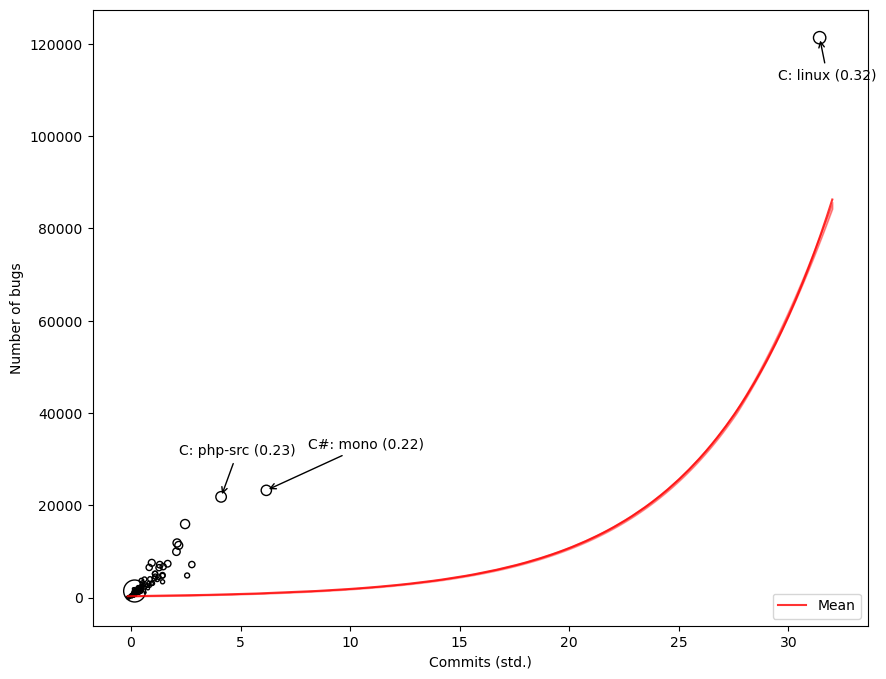

In [47]:
plt.figure(figsize=(10,8))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h3 /= pareto_k_h3.max()
pareto_k_h3_size = 250 * pareto_k_h3

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h3)[-10:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq, post_pred_h3_commits, color = 'r', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h3_commits_mean, color = 'r', alpha=0.8, label='Mean')
plt.scatter(df.commits_std, df.bugs, s = pareto_k_h3_size, facecolors='none', edgecolors='k', lw=1)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    dont_annotate = False
    if row['language'] == 'C' and row['project'] == 'linux':
        position=(-30,-30)
    elif row['language'] == 'C#' and row['project'] == 'mono':
        position=(30,30)
    elif row['language'] == 'C' and row['project'] == 'php-src':
        position=(-30,30)
    else:
        dont_annotate = True
    if dont_annotate == False:
         plt.annotate(f"{row['language']}: {row['project']} ({pareto_k_h3[index]:.2f})", xy=(row['commits_std'], row['bugs']), xytext=position,
                     textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.legend(loc = 'lower right');
plt.xlabel('Commits (std.)');
plt.ylabel('Number of bugs');

Like in H2, we see very influential data-points. To better vizualise posterior predictions of commits we "zoom-in" on data-points by removing the influential data-points from the figure.

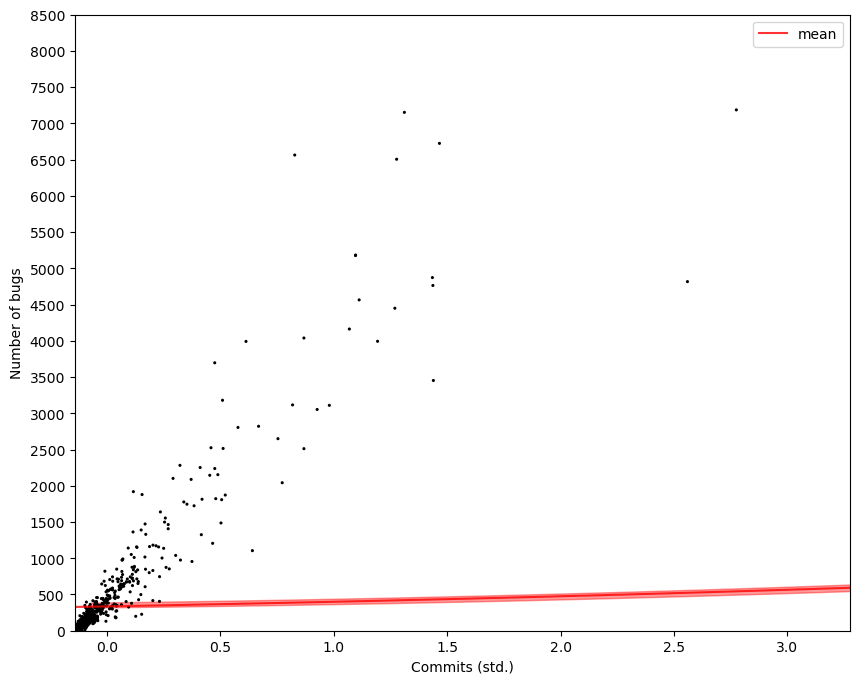

In [48]:
plt.figure(figsize=(10,8))

pareto_k_size_without_top = np.delete(pareto_k_h3_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_h3_commits, color = 'r', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_h3_commits_mean, color = 'r', alpha=0.8, label='mean')
plt.scatter(df_without_top.commits_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(min(df_without_top.commits_std), max(df_without_top.commits_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('Commits (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

The effect of commits on number of bugs is clearly not fitted well. We would have expected to see a much larger effect of commits, which would have aligned the mean prediction to the data-points. We dont know why we get such a poor fit. 

In regard to hypothesis 3, since we expect the true effect of commits to be larger than the one we estimated, we also expect the effect of age conditioned on commits to be smaller than what we estimated.

This is why we try a different approach in the next section where we model bugs as a real value.

But before that, we use information criteria to compare the models for H2 and H3.

In [49]:
pm.compare({'M2 (w/o commits)': h2_idata,
            'M3 (w commits)': h3_idata}, 
            ic='waic', scale='deviance')

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:249: RuntimeWarning: divide by zero encountered in log
  score += np.log(np.dot(exp_ic_i[i], w_full))
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:256: RuntimeWarning: invalid value encountered in scalar divide
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
M3 (w commits),0,1.107454e+06,27281.146068,0.000000e+00,0.5,1.633136e+05,0.000000e+00,True,deviance
M2 (w/o commits),1,2.362590e+06,65813.485675,1.255137e+06,0.5,1.051476e+06,1.027055e+06,True,deviance


We note that the waic is much lower in the model for H3 than the model for H2. This means that adding commits as a predictor increases the fit to the data.

## Multilevel Model H3 (w. Normal Dist.)

In [50]:
df['bug_std'] = standardize_column(df['bugs'])

In [51]:
language_idx, languages = pd.factorize(df.language)

We design a multilevel model for the normal distribution implementation of hypothesis 3. 

In hypthesis 3, we examine whether the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

In the normal distribution implementation from earlier, we saw that the effect of age drastically reduced when adding commits as a predictor. This effect was consistent for all languages and many effects were close to 0.

In this context we think it is reasonable to instruct our model that the effect of age on bugs in one language can inform the effect of age on bugs in other languages. 

In the multilevel model, expect to see a shrinkage effect, meaning that the effect of age for each language will be closer to the grand mean of age effect. 


We create a multilevel model for hypothesis 3 with a normal distribution implementation which is similar to the previous one.

The difference is that the multilevel model is extended with additional population level parameters (for the population of languages):
* $\bar{\beta}$ - effect of age across languages 
* $\gamma$ -  dispersion in effect of age across languages 

As before we model the number of standardized bugs $B$ with a Normal distribution.

$$
B_i \sim \mathcal{N}(\mu_i, \sigma)
$$

$$
\mu_i = \alpha + \beta_{A[LID]}A_i + \beta_{C[LID]}C_i
$$

We re-use the priors for the effect of commits, alpha, and sigma that we determined earlier.

$$
\beta_{C[LID]} \sim \mathcal{N}(1, 0.2)
$$

$$
\alpha \sim \mathcal{N}(0,0.5)
$$

$$
\sigma \sim \mathrm{Exponential}(1)
$$

The difference from the previous model is that information learned from a $\beta_{A}$ in one language informs the others through the shared hyper-parameters $\bar{\beta}$ and $\gamma$.

$$
\beta_{A[LID]} \sim \mathcal{N}(\bar{\beta}, \gamma)
$$

We define the hyperpriors:

$$
\bar{\beta} \sim \mathcal{N}(0, 0.2)
$$

$$
\gamma \sim \mathrm{Exponential}(1)
$$    

#### Fit model

We fit the model using the determined priors. Please note that we increase target_accept to 0.99 to ensure no divergences.

In [52]:
def create_h3_multilevel(alpha_mu_prior, alpha_sigma_prior,
                         beta_com_mu_prior, beta_com_sigma_prior, 
                         beta_bar_mu_hyperprior, beta_bar_sigma_hyperprior,
                         beta_sigma_lam_hyperprior, sigma_prior,
                         save_name='', save=False):
    with pm.Model() as model:
        
        #Hyperpriors
        beta_bar = pm.Normal('beta_bar', beta_bar_mu_hyperprior, beta_bar_sigma_hyperprior)
        beta_sigma = pm.Exponential('beta_sigma', beta_sigma_lam_hyperprior)
        
        #Priors
        alpha = pm.Normal("alpha", alpha_mu_prior, alpha_sigma_prior)
        beta_commits = pm.Normal("beta_commits", beta_com_mu_prior, beta_com_sigma_prior, shape=languages.size)
        beta_age = pm.Normal("beta_age", beta_bar, beta_sigma, shape=languages.size)
        sigma = pm.Exponential("sigma", sigma_prior)

        #We add language_ids, age_std and commits_std as mutable data so we can change it later in posterior predictions
        language_ids = pm.Data('language_ids', language_idx, mutable=True)
        age_std = pm.Data("age_std", df.age_std, mutable=True)
        commits_std = pm.Data("commits_std", df.commits_std, mutable=True)
        
        mu = pm.Deterministic("mu",
                              alpha + beta_age[language_ids] * age_std + beta_commits[language_ids] * commits_std)

        B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bug_std.values)
        
        trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4, target_accept=.99)
        
        if save == True:  
            trace.to_netcdf("./traces/"+save_name+"_.nc")

        return trace, model

In [53]:
h3_multilevel_idata, h3_multilevel_model = create_h3_multilevel(0, 0.5,
                                                                1, 0.2,
                                                                0, 0.2,
                                                                1, 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_bar, beta_sigma, alpha, beta_commits, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 124 seconds.


We note that `beta_age` now has has two hyper-parameters `beta_bar` and `beta_sigma` as expected. Besides that, the model is the same as earlier.

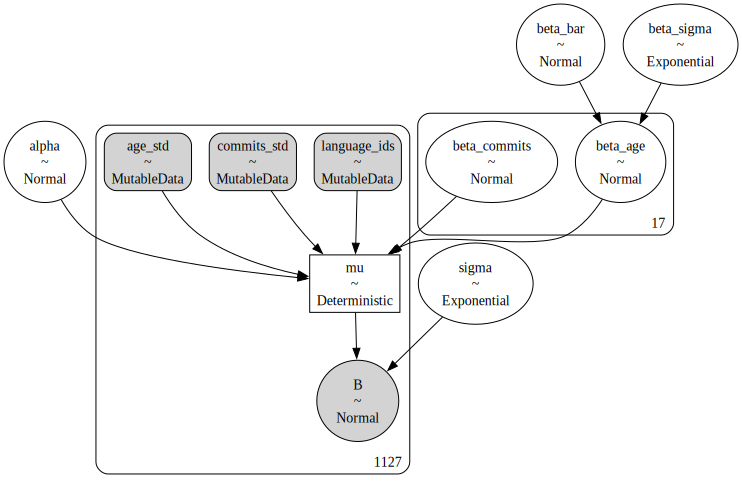

In [54]:
pm.model_to_graphviz(h3_multilevel_model)

Below is the trace convergence for the parameters .

The effective sample sizes (`ess_bulk`, `ess_tail`) are high which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation.

We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have a good mixing. This is also reflected in the plot below, which shows good mixing of the chains.

Multilevel models often have trouble to converge, but that is not the case for this model.

In [55]:
pm.summary(h3_multilevel_idata, var_names=['alpha', 'beta_age', 'beta_commits', 'sigma', 'beta_sigma', 'beta_bar'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.01,0.00,-0.01,-0.00,0.0,0.0,9402.51,6652.84,1.0
beta_age[0],0.01,0.01,-0.02,0.03,0.0,0.0,9612.00,5846.90,1.0
beta_age[1],0.01,0.00,-0.00,0.02,0.0,0.0,15459.08,6029.65,1.0
beta_age[2],0.01,0.01,-0.02,0.03,0.0,0.0,10939.57,5352.42,1.0
beta_age[3],-0.01,0.01,-0.03,0.01,0.0,0.0,7597.36,5682.71,1.0
beta_age[4],0.01,0.01,-0.01,0.03,0.0,0.0,9484.44,5903.07,1.0
beta_age[5],0.01,0.01,-0.02,0.03,0.0,0.0,8435.16,6444.98,1.0
beta_age[6],0.01,0.01,-0.01,0.03,0.0,0.0,10063.48,5487.64,1.0
beta_age[7],0.04,0.01,0.02,0.05,0.0,0.0,8097.97,6511.34,1.0
beta_age[8],0.01,0.01,-0.01,0.03,0.0,0.0,8999.77,5654.85,1.0


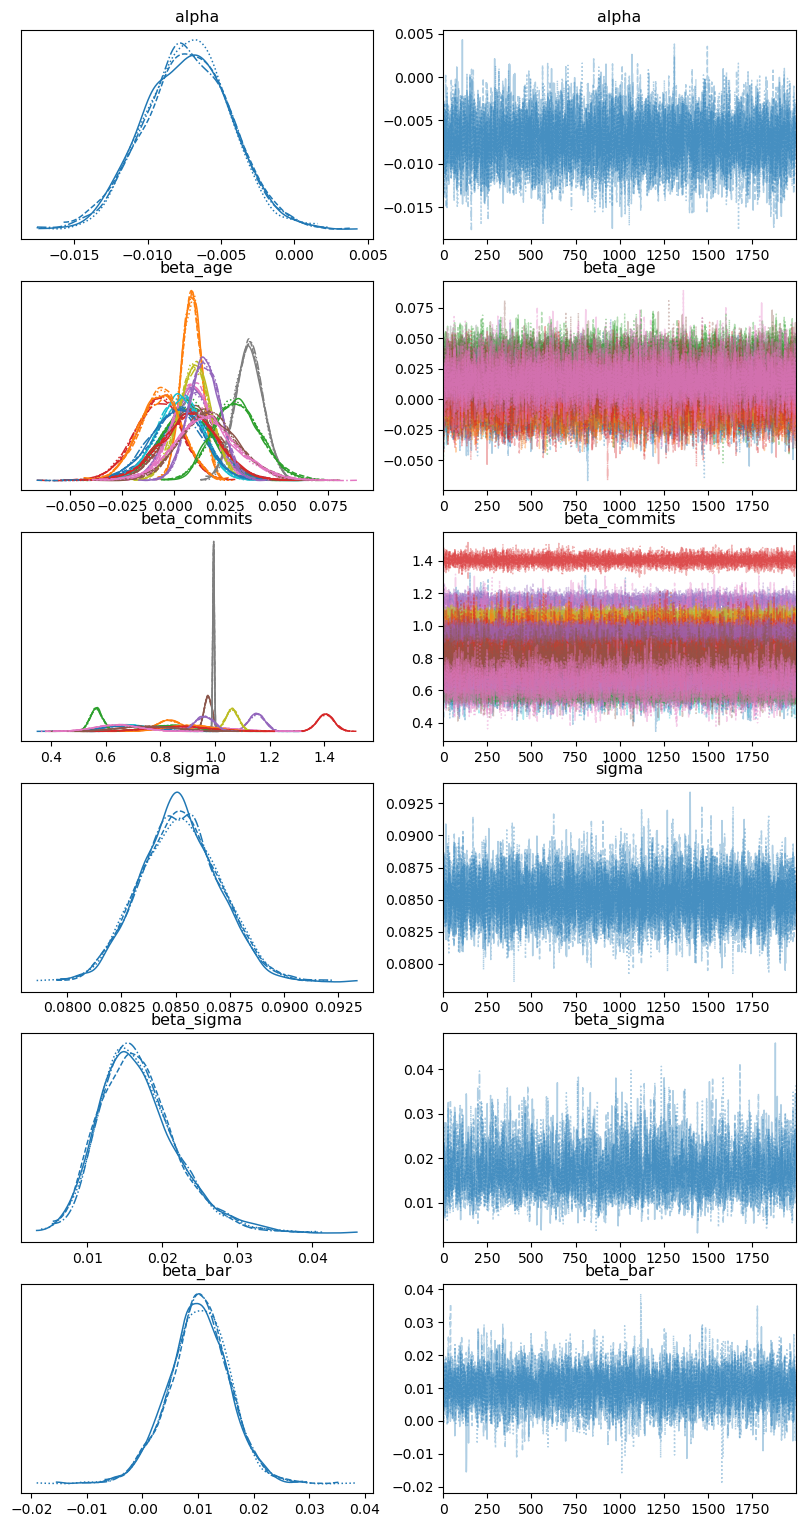

In [57]:
az.plot_trace(h3_multilevel_idata, var_names=['alpha', 'beta_age', 'beta_commits', 'sigma', 'beta_sigma', 'beta_bar'], figsize=(10,20));

Next we compare the posterior estimates for `beta_age` in the no-pooling model (the earlier implementation of h3 with normal distribution) and in the multilevel model.

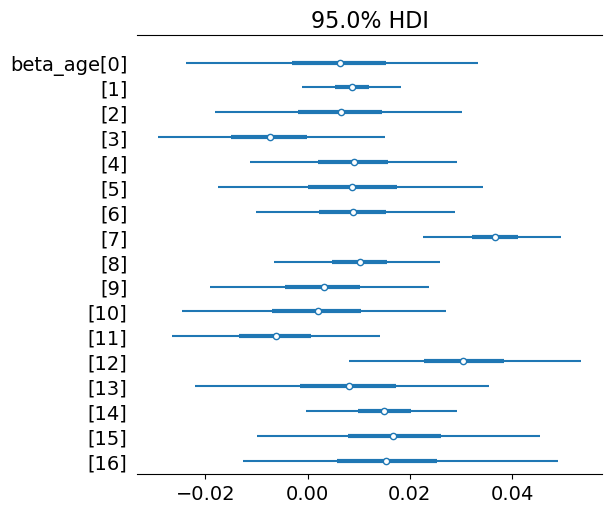

In [58]:
az.plot_forest(h3_multilevel_idata, var_names = ['beta_age'], hdi_prob=.95, combined=True);

Below is the forest plot for $\bar{\beta}$ and $\gamma$. The effect of of age across all languages $\bar{\beta}$ overlaps with 0 and is also very small.
The dispersion in the effect of age across all languages $\gamma$ is also small meaning that there is some amount of shrinkage effect. 

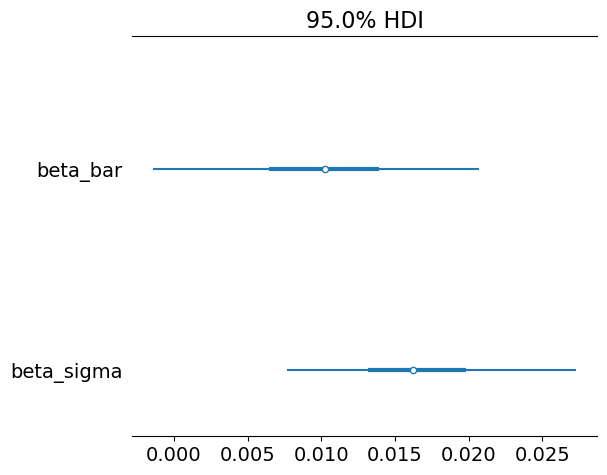

In [107]:
az.plot_forest(h3_multilevel_idata, var_names = ['beta_bar', 'beta_sigma'], hdi_prob=.95, combined=True);

Lastly we compare the no-pooling model and the multilevel model.

Note the reduced value of `p_waic`??

In [90]:
pm.compare({'Multilevel': h3_multilevel_idata,
            'No-pooling': h3_idata}, 
            ic='waic', scale='deviance')    

SyntaxError: unterminated string literal (detected at line 2) (801210976.py, line 2)